# Brain MRI Images for Brain Tumor Detection

https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
Navoneel Chakrabarty (Owner)

In [1]:
import numpy as np
import pandas as pd
import cv2
import csv
import numpy as np
from os import system
import os
import glob
import pywt
import random
import matplotlib.pyplot as plt
# Fijar la semilla de Python, NumPy y TensorFlow
seed = 13
random.seed(seed)
np.random.seed(seed)

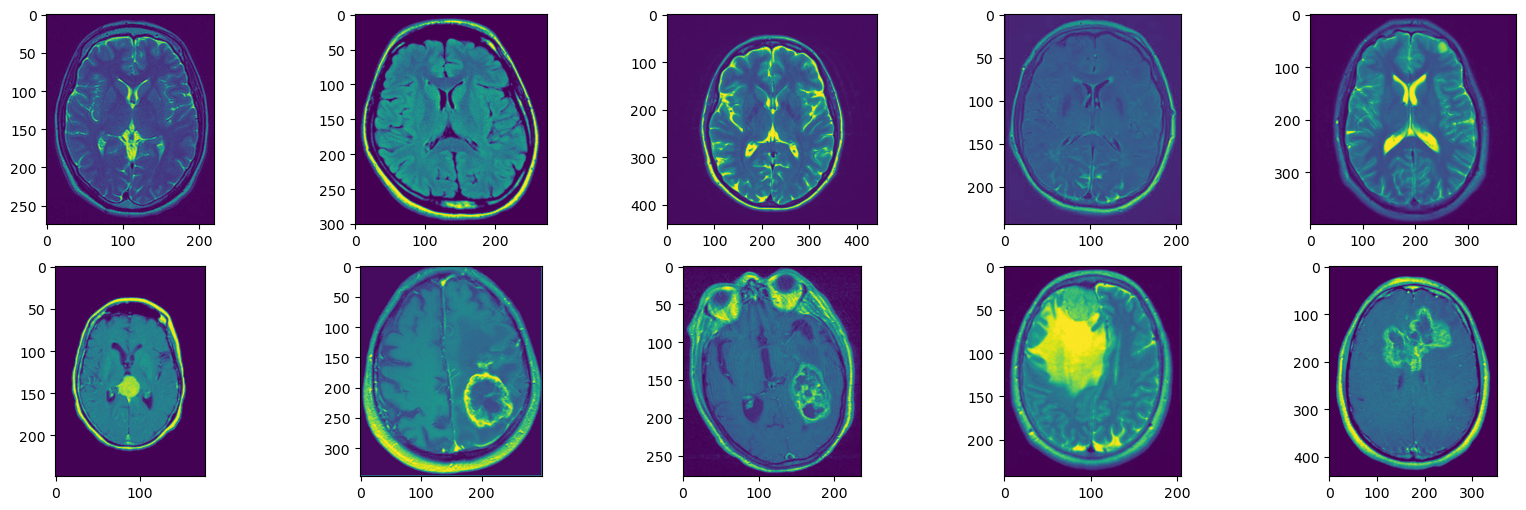

In [2]:
plt.figure(figsize=(20,6))
for j,i in enumerate(glob.glob("data/no/*")[:5]):
    plt.subplot(2,5,j+1)
    img = cv2.imread(i,0)
    plt.imshow(img)
for j,i in enumerate(glob.glob("data/yes/*")[:5]):
    plt.subplot(2,5,j+6)
    img = cv2.imread(i,0)
    plt.imshow(img)
plt.show()

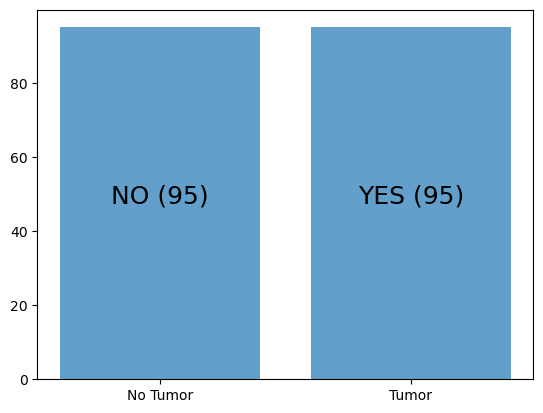

In [3]:
plt.bar(["No Tumor","Tumor"],[len(glob.glob('data/no/*')),len(glob.glob('data/yes/*'))],alpha=0.7)
plt.text(0,len(glob.glob('data/no/*'))/2,"NO ({})".format(len(glob.glob('data/no/*'))),ha="center",fontsize=18)
plt.text(1,len(glob.glob('data/yes/*'))/2,"YES ({})".format(len(glob.glob('data/yes/*'))),ha="center",fontsize=18)
plt.show()

### Etapa Previa:
1. Extracción de características desde las imágenes pertenecientes al conjunto de datos utilizando OpenCV
2. Conformación del conjunto de datos estructurado en un archivo de texto plano (csv)
3. Extranccion de las características Topológicas
4. Aplicar algoritmos de machine learning para resolver la tarea de clasificación de tres tipos de flores utilizando el dataset estructurado

In [4]:
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy
from mahotas.features import haralick

def taruma_contrast(img):
    return np.mean(np.power(np.gradient(img),2))

def taruma_directionality(img):
    gradients = np.gradient(img)
    return np.std(np.arctan2(gradients[0], gradients[1]))

def taruma_coarseness(img):
    return np.var(cv2.blur(img, (5, 5)))

def taruma_linelikeness(img):
    edges = cv2.Canny(img, 100, 200)
    return np.mean(edges)

def taruma_regularity(img):
    return np.std(cv2.blur(img, (5, 5)))

def taruma_roughness(img):
    return np.std(img)

def medidas_taruma(img):
    contrast = taruma_contrast(img)
    directionality = taruma_directionality(img)
    coarseness = taruma_coarseness(img)
    linelikeness = taruma_linelikeness(img)
    regularity = taruma_regularity(img)
    roughness = taruma_roughness(img)
    return contrast, directionality, coarseness, linelikeness, regularity, roughness

def calcular_entropia(img):
    return shannon_entropy(img)

def calcular_dimension_fractal(img):
    def box_count(img, k):
        S = np.add.reduceat(
            np.add.reduceat(img, np.arange(0, img.shape[0], k), axis=0),
            np.arange(0, img.shape[1], k), axis=1)
        return len(np.where((S > 0) & (S < k*k))[0])

    # Convertir la imagen a un binario (blanco y negro)
    img = (img > img.mean()).astype(np.uint8)
    
    # Tamanos de caja
    sizes = np.array([2, 4, 8, 16, 32, 64])
    counts = []

    for size in sizes:
        counts.append(box_count(img, size))

    # Ajuste lineal para encontrar la dimensión fractal
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

def calcular_haralick(img):
    features = haralick(img).mean(axis=0)
    return features

Dataset=[]
columns_names=[
    "taruma_contrast", "taruma_directionality", "taruma_coarseness",
    "taruma_linelikeness", "taruma_regularity", "taruma_roughness",
    "entropy", "fractal_dimension",
    "haralick_0", "haralick_1", "haralick_2", "haralick_3", "haralick_4",
    "haralick_5", "haralick_6", "haralick_7", "haralick_8",
    "haralick_9", "haralick_10", "haralick_11", "haralick_12",
    "condition", "name"
]
Dataset.append(columns_names)

In [5]:
dir_images = glob.glob('data/no/*')
class_num = 0
for file in dir_images:
    Features = []
    # Load an image
    img = cv2.imread(file, 0)
    if not img is None and img.size > 0:
        taruma_features = medidas_taruma(img)
        entropy = calcular_entropia(img)
        fractal_dimension = calcular_dimension_fractal(img)
        haralick_features = calcular_haralick(img)
        
        name = file.split("/")[-1]
        
        Features.extend(taruma_features)
        Features.append(entropy)
        Features.append(fractal_dimension)
        Features.extend(haralick_features)
        Features.append(class_num)
        Features.append(name)
    else:
        print("La imagen está vacía.")
    Dataset.append(Features)

with open('data/dataset_estructurado2.csv', 'w', newline='') as archivo_csv:
    # Creamos un objeto writer
    writer = csv.writer(archivo_csv)
    for fila in Dataset:
        writer.writerow(fila)


In [6]:
dir_images = glob.glob('data/yes/*')
class_num = 1
for file in dir_images:
    Features = []
    # Load an image
    img = cv2.imread(file, 0)
    if not img is None and img.size > 0:
        taruma_features = medidas_taruma(img)
        entropy = calcular_entropia(img)
        fractal_dimension = calcular_dimension_fractal(img)
        haralick_features = calcular_haralick(img)
        
        name = file.split("/")[-1]
        
        Features.extend(taruma_features)
        Features.append(entropy)
        Features.append(fractal_dimension)
        Features.extend(haralick_features)
        Features.append(class_num)
        Features.append(name)
    else:
        print("La imagen está vacía.")
    Dataset.append(Features)


In [7]:
with open('data/dataset_estructurado2.csv', 'w', newline='') as archivo_csv:
    # Creamos un objeto writer
    writer = csv.writer(archivo_csv)
    for fila in Dataset:
        writer.writerow(fila)

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing

In [9]:
# Carga de dataset
data = pd.read_csv('data/dataset_estructurado2.csv')

# Verificación de cargue del dataset: cabecera
data.head(10)

,taruma_contrast,taruma_directionality,taruma_coarseness,taruma_linelikeness,taruma_regularity,taruma_roughness,entropy,fractal_dimension,haralick_0,haralick_1,...,haralick_5,haralick_6,haralick_7,haralick_8,haralick_9,haralick_10,haralick_11,haralick_12,condition,name
0,239.248455,1.742498,1323.356881,29.862397,36.377972,43.022685,6.271751,1.470365,0.010304,499.617434,...,87.787279,6909.389778,7.215350,10.833065,0.000305,4.689463,-0.276873,0.983738,0,no 4.jpg
1,292.160347,1.559509,3390.690910,25.529266,58.229639,64.800272,5.700452,1.273756,0.084338,518.799129,...,135.770280,16269.404396,6.593457,9.663566,0.000487,4.403377,-0.311086,0.985177,0,no 95.jpg
2,144.337437,1.625153,2829.588675,13.646450,53.193878,56.949519,5.543258,1.169385,0.044647,254.105939,...,106.089814,12740.361393,6.441626,8.825002,0.000769,3.513754,-0.410386,0.994459,0,No21.jpg
3,174.156516,1.692760,586.292596,20.774809,24.213480,30.103807,5.854115,1.336481,0.017348,286.812648,...,107.816823,3250.345637,6.688262,9.699257,0.000632,3.890185,-0.343347,0.990071,0,no 92.jpg
4,57.064132,1.733334,2523.660566,12.973855,50.236048,51.907793,6.201083,1.127882,0.016354,99.024125,...,114.372605,10684.503262,7.156187,9.758461,0.000614,3.531200,-0.428157,0.997393,0,No17.jpg
5,49.131393,1.777709,1627.129095,7.899414,40.337688,42.215179,5.994184,1.173549,0.005359,83.565850,...,72.836349,7041.214635,6.941683,9.924715,0.000511,3.575961,-0.345278,0.991328,0,No20.jpg
6,282.081291,1.795940,1897.885658,52.012178,43.564730,50.854607,7.148673,1.517972,0.001196,537.379527,...,240.801367,9691.993973,8.051794,12.769996,0.000124,5.328479,-0.213536,0.974966,0,30 no.jpg
7,201.232145,1.531173,2236.004302,24.169248,47.286407,52.411225,5.514370,1.321313,0.098084,367.182009,...,112.091201,10616.366539,6.247221,9.198823,0.000591,4.156170,-0.339142,0.987721,0,27 no.jpg
8,301.297809,1.582271,2091.918947,24.040250,45.737500,53.298481,6.008273,1.302625,0.026857,636.607062,...,111.898235,10728.647354,6.829361,9.811221,0.000578,4.232647,-0.368726,0.993572,0,29 no.jpg
9,37.448327,1.796646,1714.883770,12.017308,41.411155,42.610870,6.057208,1.218380,0.005542,69.623412,...,98.772502,7194.356006,6.989585,10.231246,0.000575,3.792619,-0.310534,0.987635,0,no 91.jpeg


In [10]:
#obtener características generales del conjunto de datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   taruma_contrast        190 non-null    float64
 1   taruma_directionality  190 non-null    float64
 2   taruma_coarseness      190 non-null    float64
 3   taruma_linelikeness    190 non-null    float64
 4   taruma_regularity      190 non-null    float64
 5   taruma_roughness       190 non-null    float64
 6   entropy                190 non-null    float64
 7   fractal_dimension      190 non-null    float64
 8   haralick_0             190 non-null    float64
 9   haralick_1             190 non-null    float64
 10  haralick_2             190 non-null    float64
 11  haralick_3             190 non-null    float64
 12  haralick_4             190 non-null    float64
 13  haralick_5             190 non-null    float64
 14  haralick_6             190 non-null    float64
 15  harali

## Ahora de nuevo Machine Learning

In [11]:
# Librerías de modelos de ML
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Métricas para algoritmos de clasificación
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

#Partición de la data de entrenamiento
from sklearn.model_selection import train_test_split

In [12]:
Y = data["condition"]
X = data.drop(["condition","name"], axis=1)
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.35, random_state=seed)

In [13]:
x_train

,taruma_contrast,taruma_directionality,taruma_coarseness,taruma_linelikeness,taruma_regularity,taruma_roughness,entropy,fractal_dimension,haralick_0,haralick_1,...,haralick_3,haralick_4,haralick_5,haralick_6,haralick_7,haralick_8,haralick_9,haralick_10,haralick_11,haralick_12
183,105.894153,1.616799,1934.792895,18.604600,43.986281,47.141778,6.052153,1.251230,0.036992,194.931110,...,2217.966422,0.447886,109.524521,8676.934577,6.909855,9.697739,0.000605,3.772778,-0.402084,0.995988
170,51.060186,1.712878,4058.350844,12.339172,63.705187,64.939762,6.824195,1.082569,0.006300,87.496834,...,4218.174466,0.380973,171.357060,16785.201032,7.774767,10.720232,0.000483,3.763351,-0.431245,0.998490
14,291.026504,1.384617,2276.687865,24.792510,47.714650,54.637760,4.661564,1.328468,0.210211,576.538837,...,2993.121805,0.522427,85.567824,11395.948385,5.379443,7.783765,0.000929,3.850436,-0.338945,0.978395
78,83.070100,1.524587,1228.262931,19.731224,35.046582,38.074320,5.432721,1.343238,0.092414,151.140569,...,1450.481334,0.448359,71.075746,5650.784767,6.176600,8.973085,0.000625,3.774783,-0.351550,0.988628
169,192.265478,1.535884,4136.801426,30.947508,64.317971,68.023766,6.057804,1.218904,0.087866,378.325908,...,4624.807018,0.387605,144.410902,18120.902163,6.829244,10.052684,0.000492,4.391425,-0.347469,0.992433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,147.575936,1.683934,5586.836080,26.208973,74.745141,77.558865,6.950669,1.383658,0.014636,263.289786,...,6000.539170,0.332970,188.260249,23738.866892,7.863061,11.254924,0.000358,4.417821,-0.384250,0.997446
16,134.428635,1.728427,2120.117418,20.656337,46.044733,49.372879,5.696084,1.236302,0.024669,280.111030,...,2439.278862,0.424404,110.043710,9477.004417,6.575778,9.486119,0.000615,3.878607,-0.338733,0.988863
74,163.747228,1.738610,2498.206256,27.971101,49.982059,54.551479,6.949559,1.341525,0.012796,285.637900,...,2965.130819,0.297740,145.924695,11574.885375,7.847095,11.532309,0.000305,4.550988,-0.343600,0.995397
176,125.059764,1.842188,3451.344862,28.076811,58.748148,62.103478,7.752448,1.273846,0.000254,223.908548,...,3835.751641,0.176419,287.600545,15119.098016,8.731424,12.976107,0.000230,4.583573,-0.325408,0.996298


In [14]:
"""
Valores para vble 'modelo':
svm = Support Vector Machine
rf = Random forest
knn = K-Neighbors
nb = Naive bayes
dt = Decision tree
"""
trainer=None
model="rf"
if model=="svm":
  trainer = svm()
elif model=="rf":
  trainer = RandomForestClassifier(n_estimators=100,random_state=seed)
elif model=="knn":
  trainer = KNeighborsClassifier(n_neighbors=1)
elif model=="nb":
  trainer = GaussianNB()
elif model=="dt":
  trainer = DecisionTreeClassifier(random_state=seed)
else:
  print("modelo no implementado")

trainer.fit(x_train,y_train)
y_pred_test = trainer.predict(x_test)

In [15]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.79      0.82        34
           1       0.80      0.85      0.82        33

    accuracy                           0.82        67
   macro avg       0.82      0.82      0.82        67
weighted avg       0.82      0.82      0.82        67



In [16]:
MatrizConfusion = confusion_matrix(y_test,y_pred_test)
print(MatrizConfusion)

[[27  7]
 [ 5 28]]


In [17]:
# prompt: calcular kappa con la matriz de confusión almacenada en la variable MatrizConfusion
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test, y_pred_test)
print(f"El índice kappa es: {kappa}")

El índice kappa es: 0.6420302760463046
